In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed

In [2]:
import sys
module_path = '/Users/junhaoxiong 1/Documents/Projects/mgcpy'
if module_path not in sys.path:
    sys.path.append(module_path)
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.benchmarks.power import power
from mgcpy.benchmarks.simulations import *
from mgcpy.independence_tests.mgc.mgc import MGC
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.hhg import HHG
from mgcpy.independence_tests.kendall_spearman import KendallSpearman

In [3]:
def compute_distance_matrix(data_matrix_X, data_matrix_Y):
    # obtain the pairwise distance matrix for X and Y
    dist_mtx_X = squareform(pdist(data_matrix_X, metric='euclidean'))
    dist_mtx_Y = squareform(pdist(data_matrix_Y, metric='euclidean'))
    return (dist_mtx_X, dist_mtx_Y)

In [4]:
def power_vs_dimension(independence_test, simulation_type, dim_range):
    '''
    Generate power of an independence test given a simulation for a range of dimensions
    
    :param independence_test: an independence_test object
    :param simulation_type: a simulation function from mgcpy.benchmarks.simulations
    :param dim_range: the upper end of the range of dimension
    :return: power for each dimension
    '''
    estimated_power = np.zeros(dim_range)
    for d in range(1, dim_range+1):
        estimated_power[d-1] = power(independence_test, simulation_type, num_samples=100, num_dimensions=d)
    return estimated_power

In [22]:
def compute_all_power(simulation_type, dim_range):
    '''
    Compute power for each independence test for each dimension in a specified range 
    '''

    '''
    Initialize all independence test objects
    Data matrices initialized to np.nan, because in power computation each repeats involves generating new samples
    '''
    mcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='mcorr')
    dcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='dcorr')
    mantel = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='mantel')
    mgc = MGC(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix)
    rv_corr = RVCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix)
    hhg = HHG(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix)
    cca = RVCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix, which_test='cca')
    
    
    independence_tests = {'MGC': mgc, 'MCorr': mcorr, 'DCorr': dcorr, 'Mantel': mantel,
                          'RV Corr': rv_corr, 'CCA': cca}#, 'HHG': hhg}
    power_results = {}

    # compute power for each test for each dimension
    for name, test in independence_tests.items():
        power = power_vs_dimension(test, simulation_type, dim_range)
        power_results[name] = power
        print('{} finished'.format(name))    
    
    '''
    independence_tests = [mcorr, dcorr]
    power_results = Parallel(n_jobs=2)(delayed(power_vs_dimension)(test, simulation_type, dim_range) for test in independence_tests)
    '''
    
    return power_results

In [18]:
def compute_power(independence_tests, simulation_type, dim_range):
    for test in independence_tests:
        yield power_vs_dimension(test, simulation_type, dim_range)

In [ ]:
%%time
power_results = compute_all_power(square_sim, 40)

MGC finished
MCorr finished
DCorr finished
Mantel finished
RV Corr finished


In [24]:
#power_results = pickle.load(open('../../NeuroData/power_curve_sine.pkl', 'rb'))
pickle.dump(power_results, open('../../NeuroData/power_curve_step.pkl', 'wb'))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_step.pkl'>
  


In [25]:
power_results

{'CCA': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]),
 'DCorr': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]),
 'MCorr': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]),
 'MGC': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]),
 'Mantel': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]),
 'RV Corr': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.])}

In [26]:
def plot_power_curve(power_results, simulation_name):
    '''
    Plot the power of each independence test relative to mgc
    '''
    mgc_power = power_results['MGC']
    dimensions = np.arange(1, mgc_power.shape[0]+1)
    fig,ax = plt.subplots()

    for name, power in power_results.items():     
        ax.plot(dimensions, power-mgc_power, label=name)
    
    #ax.set_xticklabels([20])
    plt.xlabel('Dimensions')
    plt.ylabel('Power Relative to MGC')
    plt.legend()
    plt.gca().set_ylim(-1, 1)
    #plt.xticks(np.arange(1, mgc_power.shape[0]+1))
    plt.title('Power \n Data: {} Simulation, 100 samples'.format(simulation_name))
    plt.show()

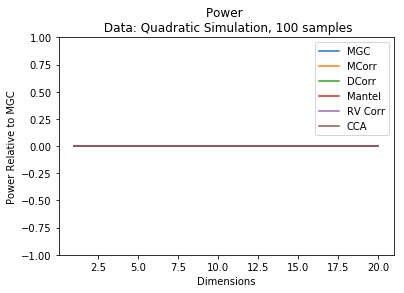

CPU times: user 207 ms, sys: 40.7 ms, total: 248 ms
Wall time: 282 ms


In [27]:
%%time
plot_power_curve(power_results, 'Quadratic')

## Results for simulations
* ones that got the correct power curve
    * quadratic, w shape, two parabolas, fourth root, 
* ones that are incorrect
    * step function, spiral, sine(?), circle (ellipse?), joint normal